In [1]:
from datasets import load_dataset
import random
from datasets import Dataset
from datasets import DatasetDict
import torch
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print(device)
MAX_LENGTH = 512

# Define a function to process each example
def process_example(example):
    # Split the example into IN and OUT parts, and remove the labels
    text = example['text']
    parts = text.split('OUT:')
    in_part = parts[0].replace('IN:', '').strip()
    out_part = parts[1].strip() if len(parts) > 1 else ''
    return {'input': in_part, 'output': out_part}

datasets = load_dataset(
    'text', 
    data_files={'train': 'data/length_split/tasks_train_length.txt',
                'test': 'data/length_split/tasks_test_length.txt'})

datasets['train'] = datasets['train'].map(process_example)
datasets['test'] = datasets['test'].map(process_example)
# Display the processed dataset
print(datasets, datasets['train'][0])

cuda:0
DatasetDict({
    train: Dataset({
        features: ['text', 'input', 'output'],
        num_rows: 16990
    })
    test: Dataset({
        features: ['text', 'input', 'output'],
        num_rows: 3920
    })
}) {'text': 'IN: walk OUT: I_WALK', 'input': 'walk', 'output': 'I_WALK'}


In [2]:

from transformers import BertTokenizer, DataCollatorWithPadding

# tokenizer = BertTokenizer.from_pretrained('bert-base-cased', force_download=False)
from transformers import BertForMaskedLM
model = BertForMaskedLM.from_pretrained("./models/checkpoint-5000", force_download=False)
model = BertForMaskedLM.from_pretrained(
    "./models/checkpoint-5000",
    torch_dtype=torch.bfloat16,
    device_map="cpu",
)
tokenizer = BertTokenizer.from_pretrained("./models/checkpoint-5000")

2025-01-13 17:02:56.716284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736784176.737933   16391 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736784176.744693   16391 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 17:02:56.770377: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn'

In [3]:
def tokenize_function(example):
    inputs = dict()
    input_str = [example["input"][idx] + tokenizer.sep_token + (' ' + tokenizer.mask_token) * MAX_LENGTH for idx in range(len(example["input"]))]
    output_str = [example["input"][idx] + tokenizer.sep_token + example["output"][idx] + (' ' + tokenizer.sep_token) * MAX_LENGTH for idx in range(len(example["input"]))]

    input_tokens = tokenizer(input_str, 
                            return_tensors='pt',
                            padding=True,
                            truncation=True,
                            max_length=MAX_LENGTH)
    output_tokens = tokenizer(output_str, 
                            return_tensors='pt',
                            padding=True,
                            truncation=True,
                            max_length=MAX_LENGTH)
    
    inputs.update(input_tokens)
    inputs['labels'] = output_tokens['input_ids']
    for idx in range(len(inputs['labels'])):
        for i in range(len(inputs['labels'][idx])):
            sep = tokenizer.convert_tokens_to_ids(tokenizer.sep_token)
            if inputs['labels'][idx][i] != sep:
                inputs['labels'][idx][i] = -100
            else:
                inputs['labels'][idx][i] = -100
                break


    return inputs
tokenized_datasets = dict()
tokenized_datasets['train'] = datasets['train']
tokenized_datasets['test'] = datasets['test'].map(tokenize_function, 
                                                  batched=True, 
                                                  remove_columns=['text', 'input', 'output'])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, max_length=512, padding=True)

Map:   0%|          | 0/16990 [00:00<?, ? examples/s]

In [9]:
import torch

# Example tensor with shape [batch size, sequence length, vocabulary]
# Replace this with your actual tensor
batch_size, sequence_length, vocab_size = 2, 4, 10
tensor = torch.rand(batch_size, sequence_length, vocab_size)

# List of target token IDs (indices in the vocabulary dimension)
target_token_ids = [1, 3, 5]

# Extract values for the target token IDs
# The result will have shape [batch size, sequence length, len(target_token_ids)]
extracted = tensor[:, :, target_token_ids]

print("Original Tensor Shape:", tensor)
print("Extracted Tensor Shape:", extracted)


Original Tensor Shape: tensor([[[0.3650, 0.6479, 0.3553, 0.5928, 0.6945, 0.6815, 0.2574, 0.9818,
          0.0539, 0.4507],
         [0.1575, 0.8538, 0.7196, 0.7528, 0.8975, 0.9830, 0.8404, 0.6889,
          0.2479, 0.4416],
         [0.8701, 0.6555, 0.8033, 0.1787, 0.4312, 0.9227, 0.8831, 0.2824,
          0.6294, 0.3561],
         [0.8446, 0.9748, 0.3041, 0.1334, 0.6202, 0.4578, 0.1957, 0.5770,
          0.8125, 0.7901]],

        [[0.5676, 0.9821, 0.0694, 0.4525, 0.9004, 0.5412, 0.9855, 0.7355,
          0.1759, 0.6683],
         [0.8367, 0.7157, 0.0182, 0.2358, 0.2196, 0.2452, 0.7233, 0.3312,
          0.1713, 0.2886],
         [0.6514, 0.7201, 0.4749, 0.1069, 0.8034, 0.7518, 0.7598, 0.4375,
          0.4227, 0.3596],
         [0.2925, 0.0766, 0.8043, 0.4895, 0.3572, 0.4608, 0.9917, 0.2013,
          0.4181, 0.5641]]])
Extracted Tensor Shape: tensor([[[0.6479, 0.5928, 0.6815],
         [0.8538, 0.7528, 0.9830],
         [0.6555, 0.1787, 0.9227],
         [0.9748, 0.1334, 0.4578]],


In [4]:
from collections import defaultdict

def calculate_accuracies(predictions, targets, input_lengths, label_lengths):
    """
    Calculate token-wise accuracy, sequence-wise accuracy, and additional accuracies:
        1. Token-level accuracy w.r.t. input sequence length
        2. Token-level accuracy w.r.t. label sequence length
        3. Sentence-level accuracy w.r.t. input sequence length
        4. Sentence-level accuracy w.r.t. label sequence length

    Args:
        predictions (list[list]): List of predicted token sequences.
        targets (list[list]): List of target token sequences.
        input_lengths (list[int]): Lengths of input sequences.
        label_lengths (list[int]): Lengths of label sequences.

    Returns:
        dict: A dictionary containing all calculated accuracies.
    """
    # Ensure predictions and targets are the same length
    assert len(predictions) == len(targets), "Predictions and targets must have the same number of sequences."
    assert len(predictions) == len(input_lengths) == len(label_lengths), \
        "Input lengths and label lengths must match the number of sequences."

    total_tokens = 0
    correct_tokens = 0
    correct_sequences = 0

    token_accuracy_wrt_input_length = defaultdict(list)
    token_accuracy_wrt_label_length = defaultdict(list)
    sequence_accuracy_wrt_input_length = defaultdict(list)
    sequence_accuracy_wrt_label_length = defaultdict(list)

    for idx, (pred_seq, target_seq, input_len, label_len) in enumerate(zip(predictions, targets, input_lengths, label_lengths)):
        # Ensure sequences are the same length
        assert len(pred_seq) == len(target_seq), "Each prediction and target sequence must have the same length."
        
        # Token-wise comparison
        sequence_correct = True
        token_correct_count = 0
        for pred_token, target_token in zip(pred_seq, target_seq):
            if pred_token == target_token:
                correct_tokens += 1
                token_correct_count += 1
            else:
                sequence_correct = False
        total_tokens += len(target_seq)

        # Sequence-level accuracy
        if sequence_correct:
            correct_sequences += 1

        # Accumulate token-level accuracy w.r.t input and label sequence length
        token_accuracy_wrt_input_length[input_len].append(token_correct_count / label_len)
        token_accuracy_wrt_label_length[label_len].append(token_correct_count / label_len)

        # Accumulate sequence-level accuracy w.r.t input and label sequence length
        sequence_accuracy_wrt_input_length[input_len].append(1 if sequence_correct else 0)
        sequence_accuracy_wrt_label_length[label_len].append(1 if sequence_correct else 0)

    # Aggregate results
    def aggregate_accuracy(data_dict):
        return {key: sum(values) / len(values) for key, values in data_dict.items()}

    aggregated_token_accuracy_input = aggregate_accuracy(token_accuracy_wrt_input_length)
    aggregated_token_accuracy_label = aggregate_accuracy(token_accuracy_wrt_label_length)
    aggregated_sequence_accuracy_input = aggregate_accuracy(sequence_accuracy_wrt_input_length)
    aggregated_sequence_accuracy_label = aggregate_accuracy(sequence_accuracy_wrt_label_length)

    # Calculate overall accuracies
    token_wise_accuracy = correct_tokens / total_tokens
    sequence_wise_accuracy = correct_sequences / len(targets)

    return {
        "token_wise_accuracy": token_wise_accuracy,
        "sequence_wise_accuracy": sequence_wise_accuracy,
        "token_accuracy_wrt_input_length": aggregated_token_accuracy_input,
        "token_accuracy_wrt_label_length": aggregated_token_accuracy_label,
        "sequence_accuracy_wrt_input_length": aggregated_sequence_accuracy_input,
        "sequence_accuracy_wrt_label_length": aggregated_sequence_accuracy_label
    }


In [5]:
def convert_string(source_string):
    # Split the string into tokens based on spaces
    tokens = source_string.split()
    # Initialize an empty list to hold the combined words
    combined_words = []
    while len(tokens) > 0:
        popped_token = tokens.pop(0)
        if popped_token != '_':
            combined_words.append(popped_token)
        elif len(tokens) > 0 and len(combined_words) > 0:
            new_word = combined_words.pop(-1) + popped_token + tokens.pop(0)
            combined_words.append(new_word)
    return combined_words

In [ ]:
import json
scan_vocabulary_ids = []

In [6]:
from torch.utils.data import DataLoader
from pprint import pprint
import torch
from tqdm import tqdm
# Evaluation
def evaluation(dataset, model, batch_size, tokenizer):
    data_loader = DataLoader(dataset, # tokenized_datasets['test'].with_format("torch") 
                             batch_size=batch_size, 
                             shuffle=False)
    targets = []
    predictions = []
    model.to(device)
    input_lengths = []
    outputs_logits = []
    labels = []
    # print(model.device, device)
    with torch.no_grad():
        for data in tqdm(data_loader):
            for key in data:
                data[key] = data[key].to(model.device)
                # print(key, data[key].device)
            # Predict
            outputs = model(**data, return_dict=True)  
            # Greedy sampling
            prediction = outputs.logits.argmax(dim=-1)
            outputs_logits.append(outputs.logits.detach().cpu()[:, :, scan_vocabulary_ids]) # ??
            # Truncation according to the length of labels
            for batch_idx in range(len(data['labels'])):
                target = []
                pre = []
                input_len = len(tokenizer.decode(data['input_ids'][batch_idx].cpu().tolist(), 
                                skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True).split())
                input_lengths.append(input_len) 
                for i in range(len(data['labels'][batch_idx])):
                    if data['labels'][batch_idx][i] != -100:
                        sep = tokenizer.convert_tokens_to_ids(tokenizer.sep_token)
                        if data['labels'][batch_idx][i] == sep: # 102
                            # Convert BERT tokens into task specific tokens
                            target_seq = convert_string(tokenizer.decode(target, 
                                                        skip_special_tokens=True, 
                                                        clean_up_tokenization_spaces=True))
                            pre_seq = convert_string(tokenizer.decode(pre, 
                                                    skip_special_tokens=True, 
                                                    clean_up_tokenization_spaces=True))
                            if len(target_seq) > len(pre_seq):
                                pre_seq += [tokenizer.sep_token] * (len(target_seq) - len(pre_seq))
                            elif len(target_seq) < len(pre_seq):
                                pre_seq = pre_seq[:len(target_seq)]
                            assert len(target_seq) == len(pre_seq), \
                                "Each prediction and target sequence must have the same length."
                            targets.append(target_seq)
                            predictions.append(pre_seq)
                            break
                        target.append(data['labels'][batch_idx][i].cpu().item())
                        labels.append(data['labels'][batch_idx].cpu())
                        pre.append(prediction[batch_idx][i].cpu().item())     
                   
        label_lengths = [len(label_seq) for label_seq in targets]
        outputs_logits = torch.cat(outputs_logits, dim=0)
        labels = torch.cat(labels, dim=0)
    return {
        'acc': calculate_accuracies(predictions, targets, input_lengths, label_lengths),
        'outputs_logits': outputs_logits,
        'labels': labels
    }

In [7]:
result_dict = evaluation(tokenized_datasets['test'].with_format("torch"), 
                     model, batch_size=1, tokenizer=tokenizer)

 10%|█         | 396/3920 [03:15<22:02:04, 22.51s/it]

: 

In [ ]:
# Save to files
torch.save(result_dict['outputs_logits'], "outputs_logits.pt")
torch.save(result_dict['labels'], "labels.pt")

In [ ]:
results = result_dict['acc']

{'token_wise_accuracy': 0.9789424668874173,
 'sequence_wise_accuracy': 0.8954081632653061,
 'token_accuracy_wrt_input_length': {8: 0.9966159396701396,
  9: 0.9621118848257004,
  4: 0.8541666666666667,
  7: 1.0,
  6: 0.9990625},
 'token_accuracy_wrt_label_length': {24: 0.9894593253968255,
  25: 0.9947321428571424,
  26: 1.0,
  27: 1.0,
  28: 0.9909119897959183,
  30: 0.9824652777777771,
  32: 0.9852818080357143,
  33: 0.9453124999999992,
  36: 0.8893229166666666,
  40: 0.9477539062500001,
  48: 0.9319661458333338},
 'sequence_accuracy_wrt_input_length': {8: 0.962890625,
  9: 0.7906698564593302,
  4: 0.75,
  7: 1.0,
  6: 0.9921875},
 'sequence_accuracy_wrt_label_length': {24: 0.9255952380952381,
  25: 0.9397321428571429,
  26: 1.0,
  27: 1.0,
  28: 0.9642857142857143,
  30: 0.8628472222222222,
  32: 0.8616071428571429,
  33: 0.7578125,
  36: 0.375,
  40: 0.75,
  48: 0.7265625}}

In [ ]:
import matplotlib.pyplot as plt
def plot_acc(action_sequence_length, accuracy, xlabel, ylabel, title, file_name):
    # Create the plot
    fig, ax1 = plt.subplots(figsize=(8, 6))  # Set figure size

    # Plot bar chart
    ax1.bar(action_sequence_length, accuracy, width=1.0, edgecolor='black')

    # Customize axes and labels
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel, color="black")
    ax1.set_title(title)

    # Add gridlines for better readability
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Save the plot as an image file
    plt.savefig(file_name, dpi=300, format="pdf", bbox_inches='tight')

    # Display the plot
    # plt.show()

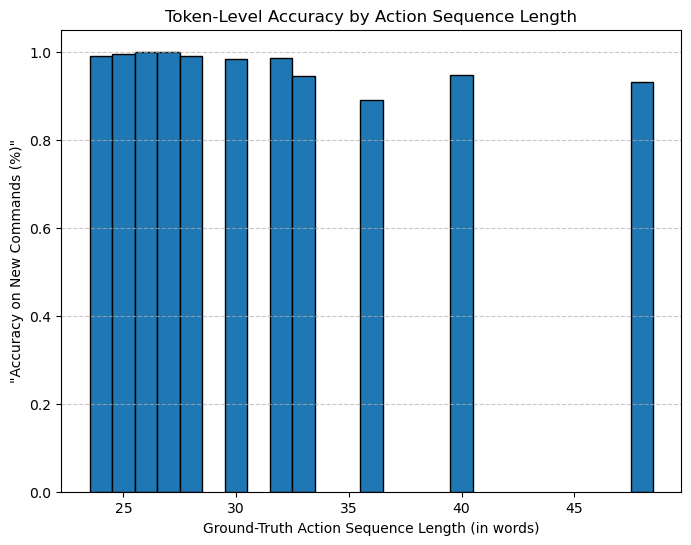

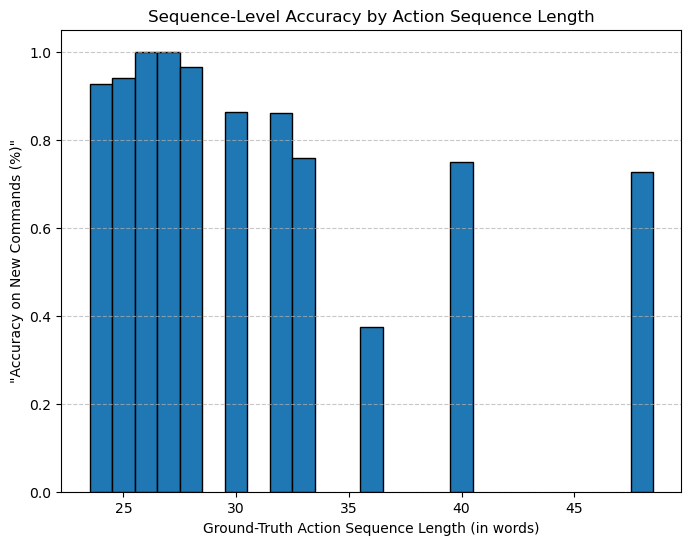

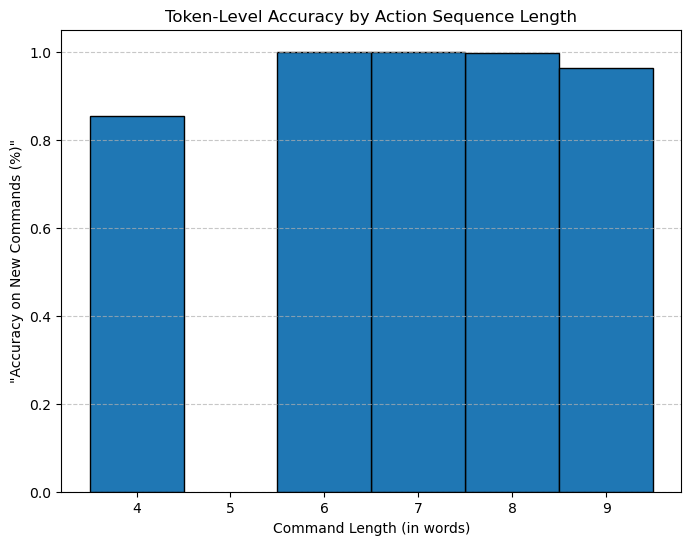

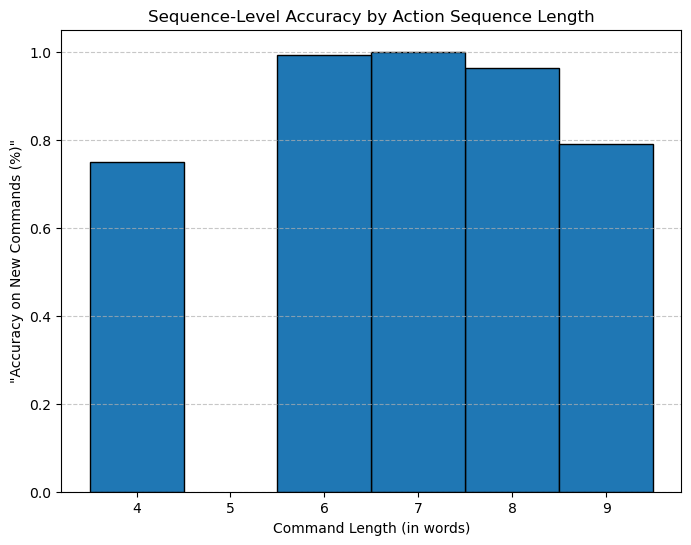

In [ ]:
accuracy_token_acc_len = list(results['token_accuracy_wrt_label_length'].keys())
accuracy_token_acc_action = [results['token_accuracy_wrt_label_length'][len] for len in accuracy_token_acc_len]
plot_acc(accuracy_token_acc_len, accuracy_token_acc_action, 
    "Ground-Truth Action Sequence Length (in words)", 
    '"Accuracy on New Commands (%)"', 
    "Token-Level Accuracy by Action Sequence Length", 
    'accuracy_token_acc_action')

accuracy_seq_acc_len = list(results['sequence_accuracy_wrt_label_length'].keys())
accuracy_seq_acc_action = [results['sequence_accuracy_wrt_label_length'][len] for len in accuracy_seq_acc_len]
plot_acc(accuracy_seq_acc_len, accuracy_seq_acc_action, 
    "Ground-Truth Action Sequence Length (in words)", 
    '"Accuracy on New Commands (%)"', 
    "Sequence-Level Accuracy by Action Sequence Length", 
    'accuracy_seq_acc_action')

accuracy_token_acc_command_len = list(results['token_accuracy_wrt_input_length'].keys())
accuracy_token_acc_command = [results['token_accuracy_wrt_input_length'][len] for len in accuracy_token_acc_command_len]
plot_acc(accuracy_token_acc_command_len, accuracy_token_acc_command, 
    "Command Length (in words)", 
    '"Accuracy on New Commands (%)"', 
    "Token-Level Accuracy by Action Sequence Length", 
    'accuracy_token_acc_command')

accuracy_seq_acc_command_len = list(results['sequence_accuracy_wrt_input_length'].keys())
accuracy_seq_acc_command = [results['sequence_accuracy_wrt_input_length'][len] for len in accuracy_seq_acc_command_len]
plot_acc(accuracy_seq_acc_command_len, accuracy_seq_acc_command, 
    "Command Length (in words)", 
    '"Accuracy on New Commands (%)"', 
    "Sequence-Level Accuracy by Action Sequence Length", 
    'accuracy_seq_acc_command')